In [26]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
y = pd.read_csv('data/y.csv').iloc[:, 0]
FS1 = pd.read_csv('data/FS1.csv', dtype=float)
PS2 = pd.read_csv('data/PS2.csv', dtype=float)

Reduce dim?

In [3]:
def reduce_time_resolution(df, stride):
    if stride == 1:
        return df
    
    df_reduced = []
    for i in range(0, df.shape[1], stride):
        df_reduced.append(df.iloc[:, i:i+stride].mean(axis=1))

    df_reduced = pd.concat(df_reduced, axis=1)
    # cast col names to str, otherwise sklearn classifier is not happy since we mix int and str col names
    df_reduced.columns = [str(i) for i in range(1, df_reduced.shape[1]+1)]

    return df_reduced

In [4]:
FS1 = reduce_time_resolution(FS1, stride=50)
PS2 = reduce_time_resolution(PS2, stride=500)

In [5]:
FS1.shape, PS2.shape

((2205, 12), (2205, 12))

Train/test split: first 2k samples will be used for the training, rest for the test.

In [6]:
n = 2000

y_train = y.iloc[:n]
FS1_train = FS1.iloc[:n, :]
PS2_train = PS2.iloc[:n, :]

y_test = y.iloc[n:]
FS1_test = FS1.iloc[n:, :]
PS2_test = PS2.iloc[n:, :]

Check data distribution in training and test sets:

In [7]:
pd.concat(
    [
        y.value_counts(normalize=True).rename('all'), 
        y_train.value_counts(normalize=True).rename('train'), 
        y_test.value_counts(normalize=True).rename('test')
    ]
    , axis=1).round(2)

,all,train,test
valve condition,,,
1,0.51,0.53,0.36
0,0.49,0.47,0.64


## Merge all features

Yes

In [8]:
# def merge_features(df1, df2):
#     return pd.merge(df1, df2, left_index=True, right_index=True)

# X_train = merge_features(FS1_train, PS2_train)
# X_test = merge_features(FS1_test, PS2_test)

No

In [8]:
# X_train = FS1_train
# X_test = FS1_test

X_train = PS2_train
X_test = PS2_test

# Base model

## Choice of the evaluation metric

Since the dataset is well balanced we could start with simple accuracy, precision or recall. Let's start with acuracy.

Check that

## Model

### Logistic regression

In [9]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

In [10]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

In [11]:
y_hat_train = clf.predict(X_train)
y_hat_train

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
(y_hat_train - y_train).mean()

0.0

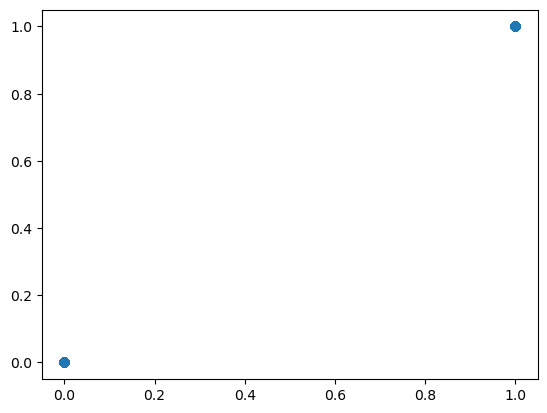

In [13]:
plt.scatter(y_train, y_hat_train)

In [14]:
clf.score(X_train, y_train)

1.0

In [15]:
clf.score(X_test, y_test)

1.0

In [16]:
clf['logisticregression'].coef_

array([[-6.32370737e-01,  1.13820330e+01, -1.06691046e+00,
         4.86267416e-01, -1.46954360e-01, -9.60571889e-02,
         4.30673814e-02, -2.32384368e-02, -9.68958614e-03,
        -3.31915556e-02, -5.76635120e-02,  3.34001030e-02]])

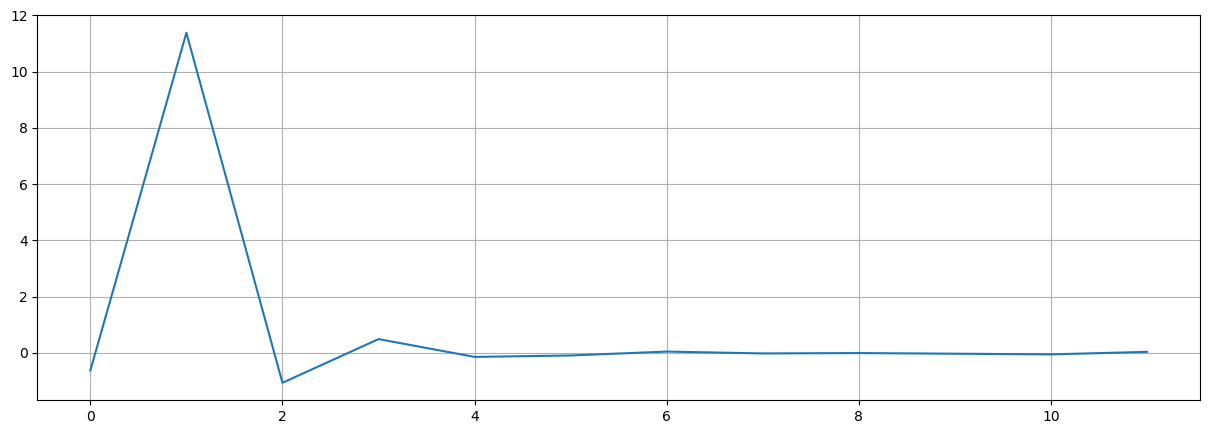

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(clf['logisticregression'].coef_[0])
ax.grid()

In [18]:
clf['logisticregression'].intercept_

array([-4.68114114])

In [19]:
X_train.to_numpy().shape

(2000, 12)

In [20]:
clf['logisticregression'].coef_.shape

(1, 12)

In [21]:
import numpy as np

v = np.array([[1, 2]])
m = np.array([[1, 2], [3, 4], [5, 6]])

v @ m.T

array([[ 5, 11, 17]])

In [22]:
clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X_train).T

array([[ 7.9375805 ,  7.55780505,  7.62315842, ..., -8.02527081,
        -9.01198853, -8.25215028]])

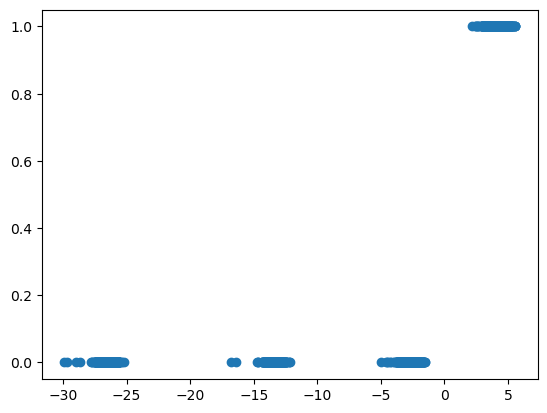

In [23]:
plt.scatter(clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X_train).T + clf['logisticregression'].intercept_, y_train)

In [24]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance

,feature,LR coef
0,1,-0.632371
1,2,11.382033
2,3,-1.066910
3,4,0.486267
4,5,-0.146954
5,6,-0.096057
6,7,0.043067
7,8,-0.023238
8,9,-0.009690
9,10,-0.033192


<Axes: xlabel='feature'>

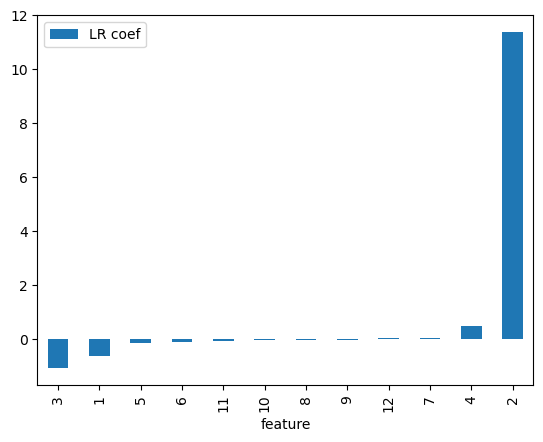

In [25]:
feature_importance.sort_values(by=['LR coef']).plot.bar(x='feature', y='LR coef')

<Axes: xlabel='feature'>

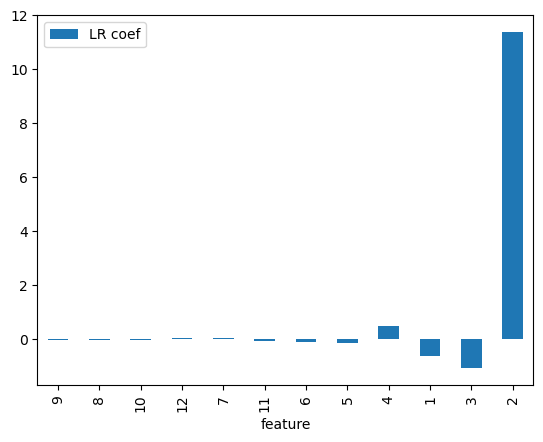

In [26]:
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).plot.bar(x='feature', y='LR coef')

Feature correlations

In [27]:
X_train.corr()

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,0.103755,0.774330,0.659733,-0.356990,-0.354124,-0.336883,-0.342279,-0.365969,-0.346092,0.292902,0.289551
2,0.103755,1.000000,0.087427,0.111691,-0.182399,-0.181638,-0.183093,-0.185490,-0.189721,-0.187251,0.041074,0.042774
3,0.774330,0.087427,1.000000,0.873379,-0.363599,-0.359043,-0.339123,-0.346754,-0.378818,-0.352818,0.367029,0.361600
4,0.659733,0.111691,0.873379,1.000000,0.099143,0.103668,0.106935,0.098635,0.064865,0.090400,0.382352,0.375599
5,-0.356990,-0.182399,-0.363599,0.099143,1.000000,0.999805,0.966424,0.966748,0.967226,0.963889,-0.029331,-0.033114
6,-0.354124,-0.181638,-0.359043,0.103668,0.999805,1.000000,0.971049,0.971302,0.971527,0.968477,-0.024976,-0.028821
7,-0.336883,-0.183093,-0.339123,0.106935,0.966424,0.971049,1.000000,0.999948,0.998947,0.998245,0.012905,0.008824
8,-0.342279,-0.185490,-0.346754,0.098635,0.966748,0.971302,0.999948,1.000000,0.999316,0.998382,0.009462,0.005432
9,-0.365969,-0.189721,-0.378818,0.064865,0.967226,0.971527,0.998947,0.999316,1.000000,0.998097,-0.004483,-0.008242
10,-0.346092,-0.187251,-0.352818,0.090400,0.963889,0.968477,0.998245,0.998382,0.998097,1.000000,0.056649,0.052838


In [28]:
import seaborn as sns

In [29]:
corrs = X_train.corr('pearson')

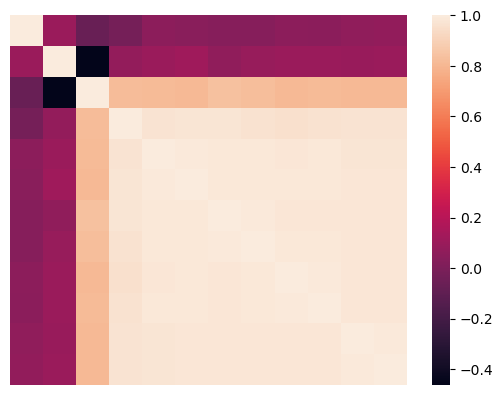

In [30]:
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

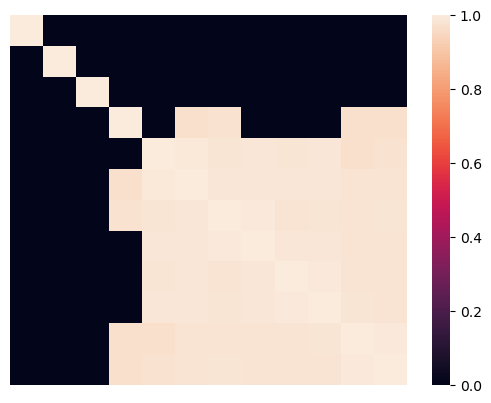

In [33]:
corrs_abs = corrs.abs()
corrs_abs[corrs_abs < 0.97] = 0

sns.heatmap(corrs_abs, annot=False, xticklabels=False, yticklabels=False);

# Try simplified model

In [41]:
# X_train_reduced = X_train.iloc[:, :2]
# X_test_reduced = X_test.iloc[:, :2]

X_train_reduced = X_train.iloc[:, [1]]
X_test_reduced = X_test.iloc[:, [1]]

In [42]:
X_train_reduced.shape, X_test_reduced.shape

((2000, 1), (205, 1))

In [43]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

In [44]:
clf.fit(X_train_reduced, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=0))])

In [45]:
y_hat_train = clf.predict(X_train_reduced)
y_hat_train

array([1, 1, 1, ..., 0, 0, 0])

In [46]:
(y_hat_train - y_train).mean()

0.0

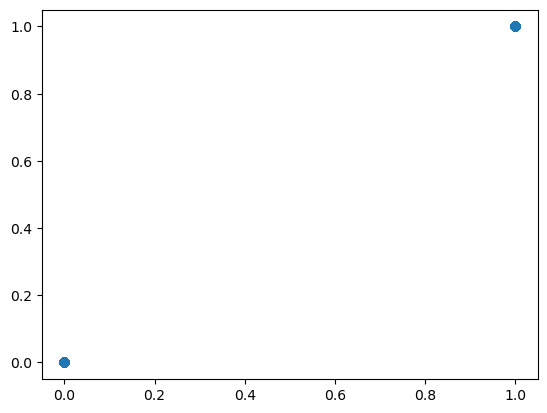

In [47]:
plt.scatter(y_train, y_hat_train)

In [48]:
clf.score(X_train_reduced, y_train)

1.0

In [50]:
clf.score(X_test_reduced, y_test)

1.0

In [61]:
clf['logisticregression'].coef_, clf['logisticregression'].intercept_

(array([[11.70660819]]), array([-4.82662209]))

It appears that the value of pressure at moment 1 (5-10seconds of the 60s cycle) decides everything.

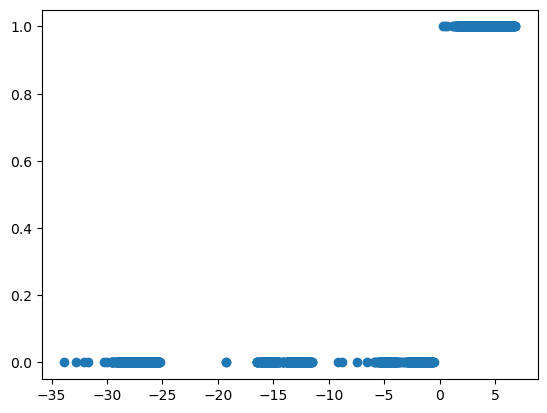

In [51]:
plt.scatter(clf['logisticregression'].coef_ @ clf['standardscaler'].transform(X_train_reduced).T + clf['logisticregression'].intercept_, y_train)

In [52]:
feature_importance = pd.DataFrame({'feature': X_train_reduced.columns, 'LR coef': clf['logisticregression'].coef_[0]})
feature_importance

,feature,LR coef
0,2,11.706608


<Axes: xlabel='feature'>

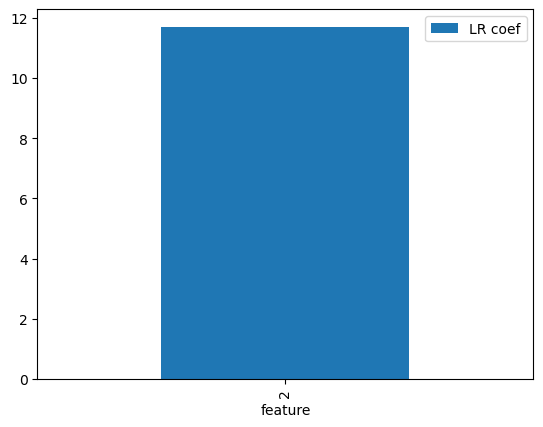

In [53]:
feature_importance.sort_values(by=['LR coef']).plot.bar(x='feature', y='LR coef')

<Axes: xlabel='feature'>

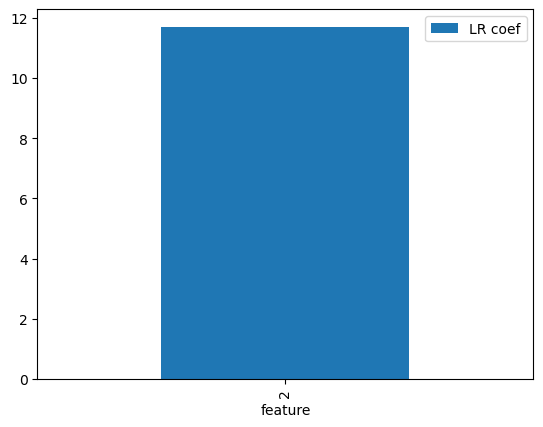

In [54]:
feature_importance['LR coef abs'] = feature_importance['LR coef'].abs()

feature_importance.sort_values(by=['LR coef abs']).plot.bar(x='feature', y='LR coef')

Feature correlations

In [55]:
X_train_reduced.corr()

,2
2,1.0


In [24]:
corrs = X_train_reduced.corr('pearson')

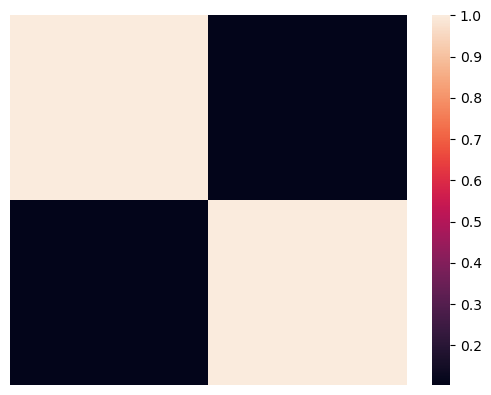

In [27]:
sns.heatmap(corrs, annot=False, xticklabels=False, yticklabels=False);

# Check visually

In [56]:
df_train = pd.DataFrame(clf['standardscaler'].transform(X_train_reduced))

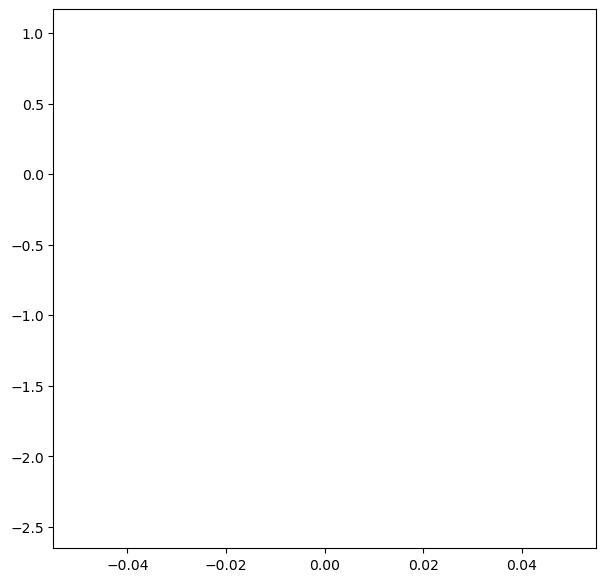

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))
for i, s in df_train.iterrows():
    c = 'r' if y_train[i] == 0 else 'b'
    ax.plot(s, c=c)

# ax.set_yscale('log')

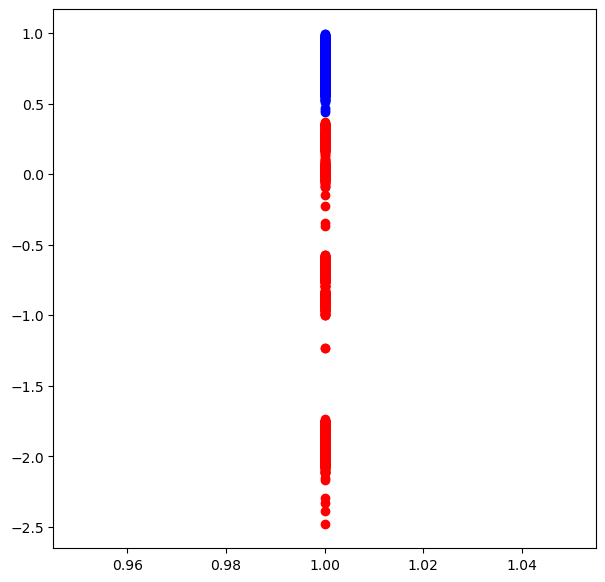

In [58]:
fig, ax = plt.subplots(figsize=(7, 7))
for i, s in df_train.iterrows():
    c = 'r' if y_train[i] == 0 else 'b'
    ax.scatter(range(1, s.size+1), s, c=c)

<Axes: >

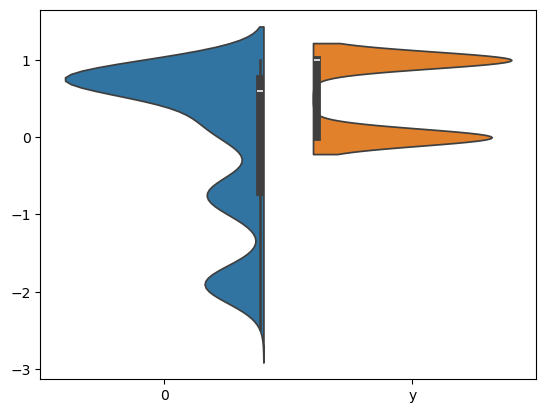

In [59]:
df = df_train.copy()
df['y'] = y_train

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=df, split=True)

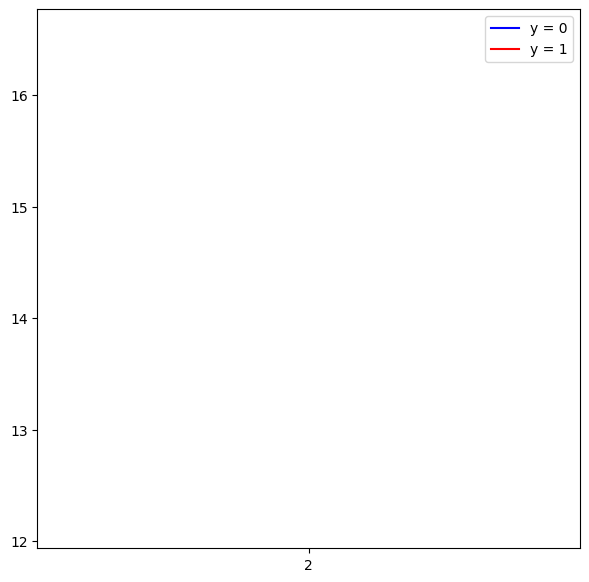

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(X_train_reduced.loc[y_train == 0, :].mean(0), c='b', label='y = 0')
ax.plot(X_train_reduced.loc[y_train == 1, :].mean(0), c='r', label='y = 1')

ax.legend()
plt.show()